In [117]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import georinex as gr
import numpy as np
import pandas as pd
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Parsing
Parse training data of three interference types: static, kinematic and natural. In each file we only parse data of GPS and Galileo (the other two are GloNass and Beidou) because information of these two constellation are recorded in every available files.

In [3]:
# Parse data:
X_static = parse_rinex('static')
X_kinematic = parse_rinex('kinematic')
X_natural = parse_rinex('natural')

Parsing ublox_static_interference.obs
Parsing novatel_static_interference.rnx
Parsing novatel_kinematic_interference.rnx
Parsing ublox_kinematic_interference.rnx
Parsing sony_kinematic_urban.rnx
Parsing sony_static_ionosphere.rnx
Parsing sony_kinematic_highway.rnx


## Data Preprocessing
- After visualization, we realize that signal strength of the observed signals is most affected by the interference. Pseudorange, carrier phase, and doppler show almost no noticable change as their graphs are really smooth. Therefore, we decided that we would heuristically consider only signal strength as an indicator for interference. Also, the number of satellite signals that can still be received can be a good indicator.
- For convenience, for each constellation, we calculate the average of signal strength of all satellites in that constellation to make the data from every setups (static, kinematic & natural) consistent, instead of using satellites individually.
- After getting average signal strength and the number of off satellites, we continue to split the time-series
into equal-size chunks. In this test, we choose window = 5 because the smallest interval in the reference data descripion is 5 seconds.

In [5]:
# Process data:
X_s, y_s = prepare_train_data('static', X_static, 5)
X_k, y_k = prepare_train_data('kinematic', X_kinematic, 5)
X_n, y_n = prepare_train_data('natural', X_natural, 5)

- The next step is that we stack all processed data together to make a single training series for training.

In [6]:
# Merge data:
X_data = {}
y_data = {}
for constell in ['G', 'E']:
    X_data[constell] = X_s[constell] + X_k[constell] + X_n[constell]
    y_data[constell] = y_s[constell] + y_k[constell] + y_n[constell]
X = stack_features(X_data)
y = stack_target(y_data)

## Traing RNN Model:
- Here we decided to use RNN to detect interference.
- Network configuration: 
    1. LSTM ayer with he initialization
    2. Fully connected layer with 64 perceptrons and relu activation
    3. Fully connected layer with 128 perceptrons and relu activation
    4. Output layer with 1 perceptron and sigmoid activation for predicting probability

In [8]:
# Train models for each constellation:
models = build_models(X, y, lr=0.001, epoch=200, batch=100, lstm=256)

Training model for GPS ....
Training model for Galileo ....


In [10]:
# Save the models for later analysis:
save_models(models)

## Visualization
- When models are ready, we move on to predict interference for test dataset. This time we have 4 datasets that might or might not contain intentional interference (some are interfered by natural causes). 

In [103]:
# Load test data:
X_test_1 = parse_rinex('test', 'Dataset1.rnx')
X_test_2 = parse_rinex('test', 'Dataset2.rnx')
X_test_3 = parse_rinex('test', 'Dataset3.rnx')
X_test_4 = parse_rinex('test', 'Dataset4.rnx')

Parsing Dataset1.rnx
Parsing Dataset2.rnx
Parsing Dataset3.rnx
Parsing Dataset4.rnx


### Dataset 1
- We can see that both constellations experience consistent interference, so we conclude that these signals are intentionally interfered.
- Near the end of the time period, we see that at some intervals there are hugh changes in average signal strength. Moreover, the number of off satellites is close to maximum, so we think that this might be signals are blocked when receiver move into building.

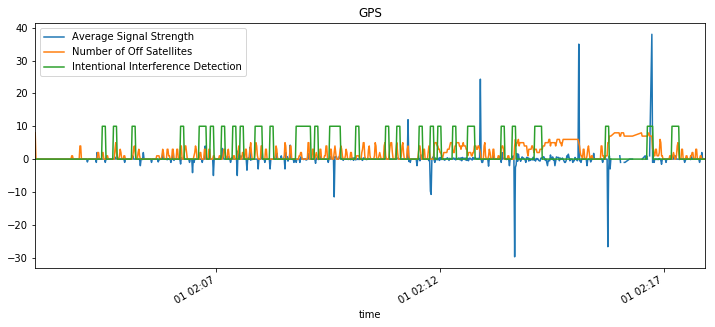

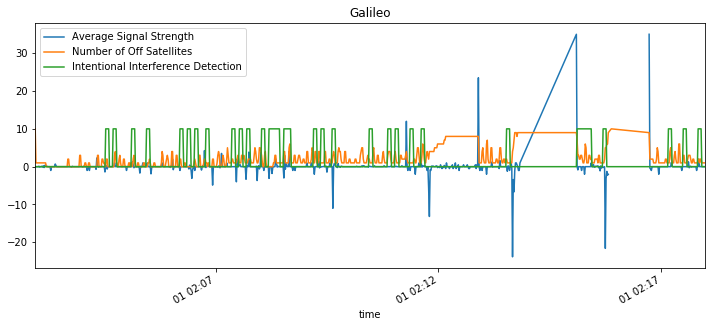

In [121]:
visualize_prediction(X_test_1, models, 5, 10)

### Dataset 2
- For periodic interference like this, it's very likely that this is natural interference. However, the models are not really accurate, because in this setting we only had 2 time intervals that had interference. 
- In order to improve the models in this case, we need data recorded in longer time period.

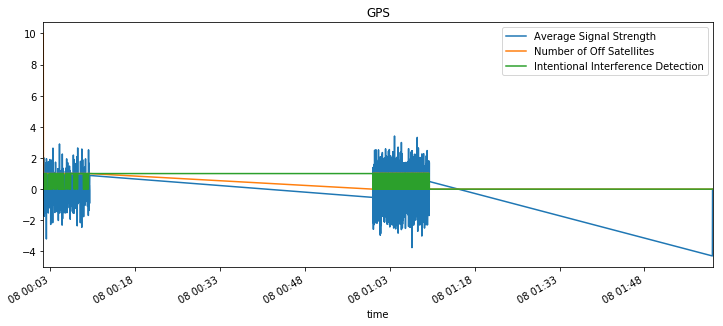

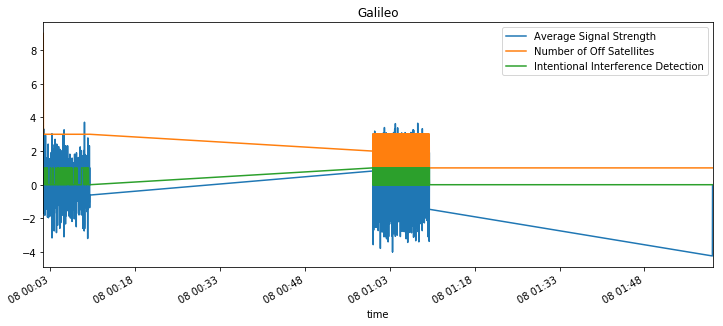

In [122]:
visualize_prediction(X_test_2, models, 5, 1)

### Dataset 3
- For this dataset, the models perform really good, as there are more training instances. We can see that there ae many periodic interfered interval, but the model robustly predict that there is no intentional interference.

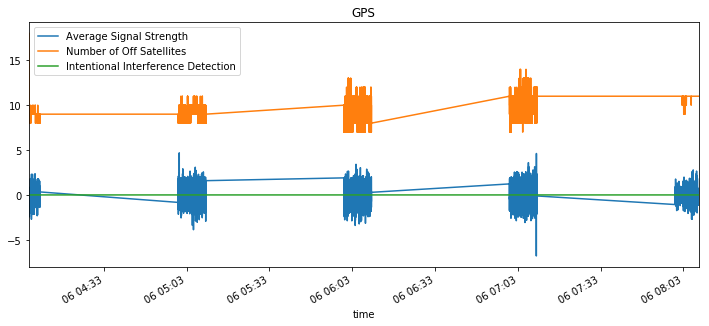

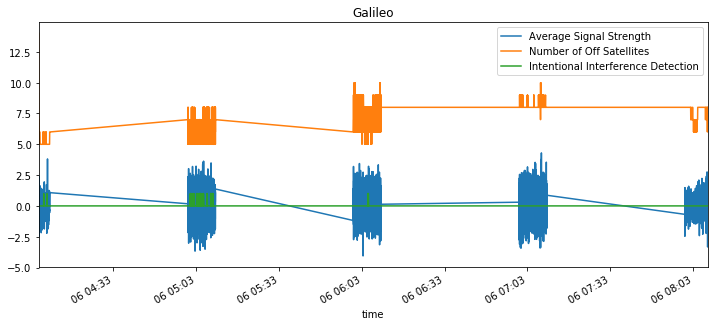

In [123]:
visualize_prediction(X_test_3, models, 5, 1)

### Dataset 4
- Just like the first dataset, we can see that both constellations experience consistent interference, so we conclude that these signals are intentionally interfered.

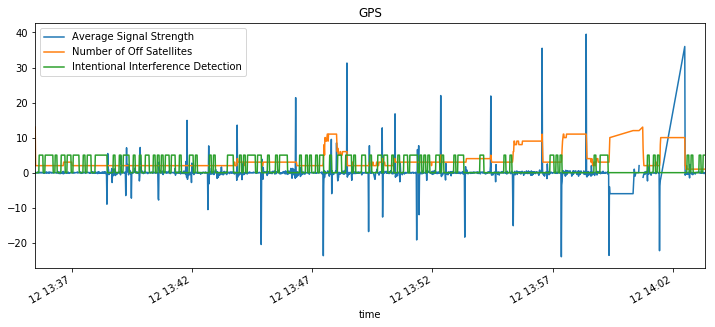

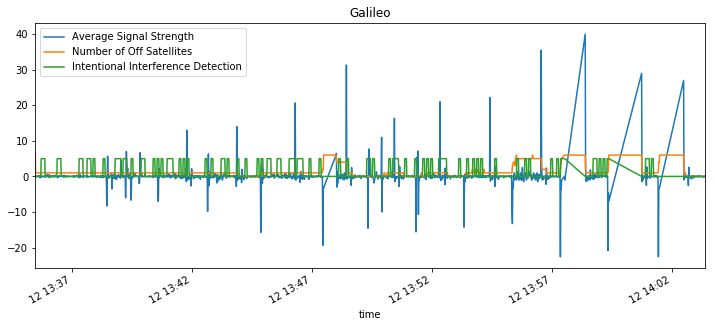

In [124]:
visualize_prediction(X_test_4, models, 5, 5)